# *On the predictability of infectious disease*, Samuel V. Scarpino & Giovanni Petri

In order to study the predictability of our time-series, we employ permutation entropy as a model-free measure of time-series predictability. The **Permutation Entropy** (PE) of a time-series $\{x_t\}$ is given by the Shannon entropy on the permutation orders, that is: 

$$H^p(\{x_t\}) = - \sum_\pi p_{\pi} log(p_{\pi})$$ 

where $p_{\pi}$ is the probability of encountering the pattern associated with permutation $\pi$. The patterns are obtained from the time-series defining an embedding dimension $m$ and following the scheme (with $m = 3$):

<img src="./images/PE.png" width="400">

Finally, the metric used is the predictability defined as $\chi = 1 - H^p$. The closer to 1 the $\chi$ is, the more regular and more deterministic the time series is. Contrarily, the smaller $\chi$ is, the more noisy and random the time series is. A time-serie that visits all the possible symblos with equal frequency will have maximal entropy and minimal predictability, and a time-series that only samples a few of the possible symbols will instead have lower entropy and hence be more predictable.

In [1]:
import PermutationEntropy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

In [17]:
# Set default setting for the figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 13) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 12) # fontsize of the tick labels
plt.rc("ytick", labelsize = 12) # fontsize of the tick labels
plt.rc("legend", fontsize = 12) # legend fontsize
plt.rcParams.update({'font.size': 15})

In [3]:
COUNTRIES = ["Yemen", "Syria", "Burkina Faso", "Nigeria", "Mali", "Cameroon"]

In [4]:
res = []
for COUNTRY in COUNTRIES:
    df = pd.read_csv(f"../Data Sources/2. Food Consumption Score (FCS)/output_timeseries/{COUNTRY}/wfp_fcs-interpolate.csv", index_col = 0, header = [0, 1])
    df.index = pd.to_datetime(df.index)
    df.index.name = "Datetime"
    df.index.freq = "D"

    # Define the number of iteration you want to perform.
    n_iter = 1000
    # The min length of the temporal window to generate the subsample time-series.
    min_window_length = 10
    # The max length of the temporal window to generate the subsample time-series.
    max_window_length = 100

    ms = np.arange(2, 7 + 1) # Find the best embedding dimension for each iteration.

    tqdm.pandas()
    results = df.groupby(axis = 1, level = [0, 1]).progress_apply(lambda x: PermutationEntropy.PE_scaling_with_amount_of_data(x, n_iter, ms, min_window_length = min_window_length, max_window_length = max_window_length))
    results = results.stack([0, 1]).droplevel(axis = 0, level = 0)

    y = results["PE"]
    x = results["n"]

    ent = y.groupby(by = x).apply(np.mean).values
    ent_low = y.groupby(by = x).apply(lambda x: x.quantile(q = 0.25)).values
    ent_high = y.groupby(by = x).apply(lambda x: x.quantile(q = 0.75)).values
    n = y.groupby(by = x).apply(np.mean).index

    results = pd.DataFrame({"Chi": 1 - ent, "n": n, "Chimax": 1 - ent_low, "Chimin": 1 - ent_high})
    
    res.append(results)

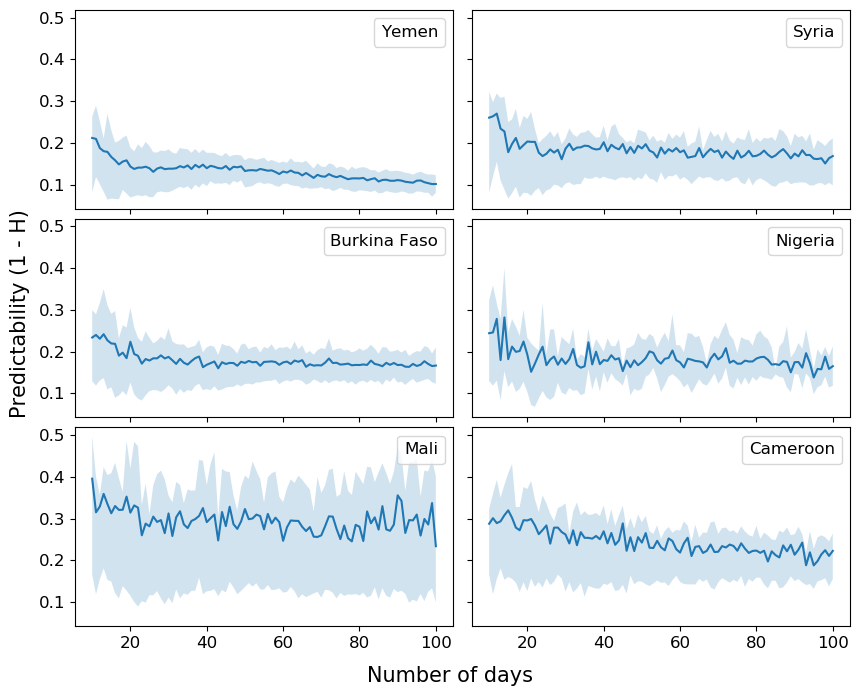

In [19]:
# Plot the original time-series of the FCG indicator for each country.
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 8), sharey = True, sharex = True)
fig.subplots_adjust(hspace = .05, wspace = .05)
axs = axs.ravel()
for i, country in enumerate(COUNTRIES):
    res[i].plot(ax = axs[i], x = "n", y = "Chi", label = country)
    axs[i].fill_between(x = "n", y1 = "Chimax", y2 = "Chimin", data = res[i], alpha = 0.2)
    axs[i].set_xlabel("")
    leg = axs[i].legend(handlelength=0, handletextpad=0, fancybox=True)
    for item in leg.legendHandles:
        item.set_visible(False)

fig.text(0.06, 0.5, "Predictability (1 - H)", va='center', rotation='vertical')
fig.text(0.5, 0.04, "Number of days", ha='center')

fig.savefig(f"./output_images/all.png" , bbox_inches = "tight", dpi = 600)